In [1]:
import xarray as xr
import numpy as np
import glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib as mpl
from scipy.ndimage.filters import uniform_filter
from pyproj import Transformer
from datetime import datetime, timedelta
from tqdm import tqdm

/tmp/ipykernel_7583/961378989.py:15: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter


In [2]:
def generate_array(data, lonlatbox):
    """
    Generate a subarray from the given data based on the specified bounding box in longitude and latitude.

    Parameters:
    - data (xarray.Dataset): The input dataset containing the required variable ('crr_intensity').
    - lonlatbox (tuple): A tuple representing the bounding box in the form (min_lon, max_lon, min_lat, max_lat).

    Returns:
    - zam_array (numpy.ndarray): The subarray of 'crr_intensity' values.
    - x_coords (numpy.ndarray): The x coordinates corresponding to the columns of zam_array.
    - y_coords (numpy.ndarray): The y coordinates corresponding to the rows of zam_array.
    """
    
    # Extracting bounding box coordinates
    min_lon = lonlatbox[0]
    max_lon = lonlatbox[1]
    min_lat = lonlatbox[2]
    max_lat = lonlatbox[3]

    # Geostationary projection setup
    proj = ccrs.Geostationary(central_longitude=0.0, satellite_height=35785831)
    transformer_from_latlon = Transformer.from_crs("EPSG:4326", proj.to_proj4(), always_xy=True)
    
    # Transforming latlon coordinates to projection coordinates
    min_x, max_y = transformer_from_latlon.transform(min_lon, max_lat)
    max_x, min_y = transformer_from_latlon.transform(max_lon, min_lat)
    
    # Selecting the data within the specified lonlatbox
    zam = data.sel(nx=slice(min_x, max_x), ny=slice(max_y, min_y))
    
    # Extracting coordinates from the selected data
    x_coords = zam.nx.values
    y_coords = zam.ny.values
    
    # Creating a numpy array with 'crr_intensity' values
    zam_array = np.flipud(zam['crr_intensity'].values)

    return zam_array, x_coords, y_coords


In [3]:
def nowcast_obs_generator(date, lead_time_mins, lonlatbox):
    """
    Generate nowcast and observed arrays for a given date, lead time, and bounding box.

    Parameters:
    - date (str): The date in the format 'YYYYMMDD'.
    - lead_time_mins (int): Lead time in minutes.
    - lonlatbox (tuple): A tuple representing the bounding box in the form (min_lon, max_lon, min_lat, max_lat).

    Returns:
    - nowcast_arrays (numpy.ndarray): An array containing nowcast data arrays for each available file.
    - obs_arrays (numpy.ndarray): An array containing observed data arrays for each available file.
    - init_time_list (list): A list of initialization times corresponding to each nowcast and observed pair.
    """
    
    # Format lead time to ensure proper matching with file names
    lead_time_mins = "{0:03d}".format(lead_time_mins)
    
    # Retrieve file paths for nowcast and observed data
    nowcast_files = glob.glob('/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/*EXIM*')
    obs_files = glob.glob('/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/*_CRR_*')

    # Filter nowcast files based on lead time
    nowcast_files = [file for file in nowcast_files if file[-6:-3] == lead_time_mins]
    
    # Lists to store nowcast arrays, observed arrays, and initialization times
    nowcast_list = []
    obs_list = []
    init_time_list = []
    
    # Iterate through each nowcast file
    for file in nowcast_files:
        
        # Extract initialization time from file name
        init_time = file[-14:-10]
        dt_init_time = datetime.strptime(init_time, '%H%M')
        
        # Calculate valid time based on lead time
        valid_time = (dt_init_time + timedelta(minutes=int(lead_time_mins))).strftime('%H%M')
        
        # Construct observed file path based on date and valid time
        obs_file = '/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/S_NWC_CRR_MSG3_Africa-VISIR_' + date + 'T' + valid_time + '00Z.nc'

        try:
            # Open nowcast and observed datasets
            nowcast_data = xr.open_dataset(file)
            obs_data = xr.open_dataset(obs_file)
    
            # Generate nowcast and observed arrays based on lonlatbox
            nowcast_array, x_coords, y_coords = generate_array(nowcast_data, lonlatbox)
            obs_array, x_coords, y_coords = generate_array(obs_data, lonlatbox)
    
            # Append arrays and initialization time to respective lists
            nowcast_list.append(nowcast_array)
            obs_list.append(obs_array)
            init_time_list.append(init_time)
            
        except Exception as e:
            # Print any exceptions encountered during data processing
            print(e)

    return np.array(nowcast_list), np.array(obs_list), init_time_list


In [4]:
def fss(thr, scale, X_f, X_o):
    """
    Compute the Fractions Skill Score (FSS) between forecast and observed fields.

    Parameters:
    - thr (float): The intensity threshold for defining binary fields.
    - scale (int): The scale for computing the moving average of binary fields.
    - X_f (numpy.ndarray): The forecast field.
    - X_o (numpy.ndarray): The observed field.

    Returns:
    - float: Fractions Skill Score (FSS) between forecast and observed fields.
    """

    # Check if input arrays are two-dimensional and have the same shape
    if len(X_f.shape) != 2 or len(X_o.shape) != 2 or X_f.shape != X_o.shape:
        message = "X_f and X_o must be two-dimensional arrays having the same shape."
        raise ValueError(message)
    
    # Convert nan's to a value below the threshold
    X_f = X_f.copy()
    X_f[~np.isfinite(X_f)] = thr * 0.1
    X_o = X_o.copy()
    X_o[~np.isfinite(X_o)] = thr * 0.1

    # Convert to binary fields with the given intensity threshold
    I_f = (X_f >= thr).astype(float)
    I_o = (X_o >= thr).astype(float)

    # Compute fractions of pixels above the threshold within a square
    # neighboring area by applying a 2D moving average to the binary fields
    if scale > 1:
        S_f = uniform_filter(I_f, size=scale, mode="constant", cval=0.0) * scale
        S_o = uniform_filter(I_o, size=scale, mode="constant", cval=0.0) * scale
    else:
        S_f = I_f
        S_o = I_o

    # Calculate components for FSS computation
    sum_obs_sq = np.nansum(S_o**2)
    sum_fct_obs = np.nansum(S_f * S_o)
    sum_fct_sq = np.nansum(S_f**2)
    
    numer = sum_fct_sq - 2.0 * sum_fct_obs + sum_obs_sq
    denom = sum_fct_sq + sum_obs_sq

    return 1.0 - numer / denom


In [5]:
def fss_spatial(obs, pred, thr, scale):
    """
    Compute the Fractional Skill Score (FSS) for spatial fields between observed and predicted data.

    Parameters:
    - obs (numpy.ndarray): The observed spatial field over time.
    - pred (numpy.ndarray): The predicted spatial field over time.
    - thr (float): The intensity threshold for defining binary fields.
    - scale (int): The scale for computing the moving average of binary fields.

    Returns:
    - fss (numpy.ndarray): The Fractional Skill Score (FSS) spatial field.
    """

    # Initialize variables
    num_zeros = []
    fss_score = np.empty((pred.shape[0], pred.shape[1], pred.shape[2]))
    O_F = np.zeros((pred.shape[1], pred.shape[2]))
    O2_F2 = np.zeros((pred.shape[1], pred.shape[2]))

    # Iterate through each time step
    for i in range(fss_score.shape[0]):
        
        X_f = pred[i, :, :] 
        X_o = obs[i, :, :]

        # Convert nan's to a value below the threshold
        X_f = X_f.copy()
        X_f[~np.isfinite(X_f)] = thr * 0.1
        X_o = X_o.copy()
        X_o[~np.isfinite(X_o)] = thr * 0.1
        
        # Convert to binary fields with the given intensity threshold
        I_f = (X_f >= thr).astype(float)
        I_o = (X_o >= thr).astype(float)
        
        # Compute fractions of pixels above the threshold within a square
        # neighboring area by applying a 2D moving average to the binary fields
        if scale > 1:
            S_f = uniform_filter(I_f, size=scale, mode="constant", output=float, cval=0.0) * (scale**2)
            S_o = uniform_filter(I_o, size=scale, mode="constant", output=float, cval=0.0) * (scale**2)
        else:
            S_f = I_f
            S_o = I_o
        
        # Handle artifacts due to the inability to represent exactly zero
        S_f[(S_f < 0) | (S_f < 0.001)] = 0
        S_o[(S_o < 0) | (S_o < 0.001)] = 0    
        
        # FSS calculation
        O_F = np.sum([O_F, S_o * S_f], axis=0)
        O2_F2 = np.sum([O2_F2, (S_o**2 + S_f**2)], axis=0)
        
    fss = 2 * (O_F / O2_F2)

    return fss


In [6]:
# Zambia domain:
min_lon = 20
max_lon = 35
min_lat = -18
max_lat = -8

# # SW Zambia domain
# min_lon = 24
# max_lon = 30
# min_lat = -17
# max_lat = -14

domain = [min_lon, max_lon, min_lat, max_lat]

In [7]:
date = '20240130'
init_times = ["{:02d}00".format(n) for n in range(13,24)] # initialization times of interest
dpi_set = 300

In [8]:
init_times

['1300',
 '1400',
 '1500',
 '1600',
 '1700',
 '1800',
 '1900',
 '2000',
 '2100',
 '2200',
 '2300']

In [9]:
# # Get nowcast initialisation times
# pred_files = glob.glob('/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/*-CRR_*' + 'Z_' + '*.nc')

# init_times = []
# for file in pred_files:
#     init_times.append(file[-14:-10])    

# init_times = np.unique(np.array(init_times))

## Verification

In [10]:
# Total FSS

In [11]:
total_fss = np.zeros((len(init_times), 24))*np.nan

In [12]:
for j, init_time in enumerate(tqdm(init_times)):
    # Loop through each initialization time and enumerate

    # Extract datetime object from initialization time string
    dt_time = datetime.strptime(init_time, '%H%M')
    
    # Generate observation times and corresponding lead times
    obs_times = [datetime.strftime(dt_time + timedelta(minutes=15 * n), '%H%M') for n in range(1, 25)]
    lead_times = ["{:03d}".format(15 * n) for n in range(1, 25)]
    
    # Create file paths for prediction and observation files based on date, initialization time, and lead time
    pred_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/S_NWC_EXIM-CRR_MSG3_Africa-VISIR_' + date + 'T' + init_time + '00Z_' + lead + '.nc' for lead in lead_times]
    obs_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/S_NWC_CRR_MSG3_Africa-VISIR_' + date + 'T' + obs + '00Z.nc' for obs in obs_times]

    # Check if prediction files are not found, then use temporary file paths
    if not pred_files:
        pred_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/temp/' + date + '/CRR/S_NWC_EXIM-CRR_MSG3_Africa-VISIR_' + date + 'T' + init_time + '00Z_' + lead + '.nc' for lead in lead_times]
        obs_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/temp/' + date + '/CRR/S_NWC_CRR_MSG3_Africa-VISIR_' + date + 'T' + obs + '00Z.nc' for obs in obs_times]

    # Raise an error if no prediction files are found
    if not pred_files:
        raise FileNotFoundError("No prediction files found.")
    
    # Initialize a list to store FSS scores for each lead time
    f = [np.nan for i in range(24)]
    
    # Loop through each pair of prediction and observation files
    for i in range(len(pred_files)):
        
        try:
            # Open prediction and observation datasets
            pred = xr.open_dataset(pred_files[i])
            obs = xr.open_dataset(obs_files[i])
        
            # Generate prediction and observation arrays based on lonlatbox
            pred_array, _, _ = generate_array(data=pred, lonlatbox=domain)
            obs_array, _, _ = generate_array(data=obs, lonlatbox=domain)    
            
            # Check if there are NaN values in the observation array
            if np.isnan(obs_array).any() == True:
                f[i] = np.nan
            else:
                # Calculate FSS score and store it in the list
                fss_score = fss(1, 10, pred_array, obs_array)
                f[i] = fss_score
    
        except Exception as e:
            # Print any exceptions encountered during data processing and continue to the next pair
            print(e)
            continue

    # Store the list of FSS scores for the current initialization time in the total_fss array
    total_fss[j] = f


  0%|          | 0/11 [00:00<?, ?it/s]/opt/jaspy/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
100%|██████████| 11/11 [00:49<00:00,  4.48s/it]


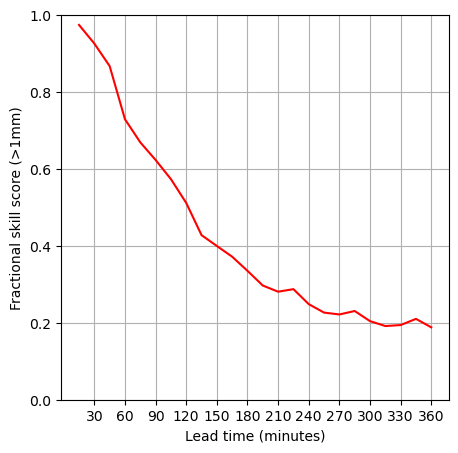

In [13]:
# Plot FSS average over all initiation times
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot([15*n for n in range(24)], np.nanmean(total_fss, axis=0), color = 'red', label = '20 km')
ax.set_xticks([15+30*n for n in range(12)])
ax.set_xticklabels([30*n for n in range(1,13)])
ax.set_xlabel('Lead time (minutes)')
ax.set_ylabel('Fractional skill score (>1mm)')
ax.set_ylim(0,1)
plt.grid(True)
plt.savefig(date+'_fss_avg.png', bbox_inches='tight')
plt.show()

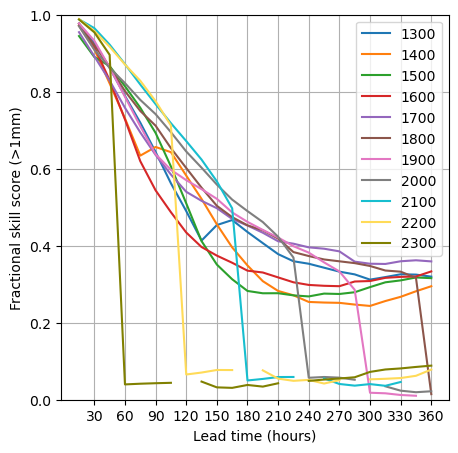

In [14]:
# Plot FSS per initialisation time
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

matplotlib_color_codes = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#17becf',  # Cyan
    '#ffdb58',  # Yellow
    '#808000',  # Olive
    '#008080',  # Teal
    '#ff00ff'   # Magenta
]

for i in range(total_fss.shape[0]):
    ax.plot([15*n for n in range(24)], total_fss[i], color = matplotlib_color_codes[i], label = init_times[i])  

ax.set_xticks([15+30*n for n in range(0,12)])
ax.set_xticklabels([30*n for n in range(1,13)])
ax.set_xlabel('Lead time (hours)')
ax.set_ylabel('Fractional skill score (>1mm)')
ax.set_ylim(0,1)
plt.grid(True)
plt.legend()
plt.savefig(date+'_fss_all_inits.png', bbox_inches='tight')
plt.show()

In [15]:
# Get projection coordinates from anz nowcast file
ipath ='/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_EXIM-CRR_MSG3_Africa-VISIR_20240129T100000Z_015.nc'
data = xr.open_dataset(ipath)
_,  x_coords, y_coords = generate_array(data = data, lonlatbox = domain)


In [16]:
# Read data for spatial FSS

In [17]:
# Initialize empty lists to store prediction arrays, observation arrays, and corresponding times
all_pred = []
all_obs = []
all_times = []

# Loop through each initialization time and enumerate
for j, init_time in enumerate(tqdm(init_times)):

    # Set observation time to be the same as initialization time
    obs_time = init_time
    
    # Create file paths for prediction and observation files based on date and initialization time
    pred_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/S_NWC_EXIM-CRR_MSG3_Africa-VISIR_' + date + 'T' + init_time + '00Z_120.nc']
    obs_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/S_NWC_CRR_MSG3_Africa-VISIR_' + date + 'T' + init_time + '00Z.nc' for obs in obs_times]

    # Loop through each pair of prediction and observation files
    for i in range(len(pred_files)):
    
        try:
            # Open prediction and observation datasets
            pred = xr.open_dataset(pred_files[i])
            obs = xr.open_dataset(obs_files[i])
    
            # Generate prediction and observation arrays based on lonlatbox
            pred_array, _, _ = generate_array(pred, domain)
            obs_array, _, _ = generate_array(obs, domain)    
        
            # Check if there are no NaN values in the observation array
            if np.isnan(obs_array).any() == False:
                # Append prediction array, observation array, and corresponding time to the lists
                all_pred.append(pred_array)
                all_obs.append(obs_array)
                all_times.append(obs_time)
                
        except Exception as e:
            # Print any exceptions encountered during data processing and continue to the next pair
            print(e)
            continue
            
# Convert the lists to numpy arrays
all_pred = np.array(all_pred) 
all_obs = np.array(all_obs)


100%|██████████| 11/11 [00:01<00:00,  5.96it/s]


In [18]:
# Spatial FSS

In [19]:
# Compute skill map
skill_map = fss_spatial(all_obs, all_pred, 1, 10)

/tmp/ipykernel_7583/2097764549.py:54: RuntimeWarning: invalid value encountered in divide
  fss = 2 * (O_F / O2_F2)


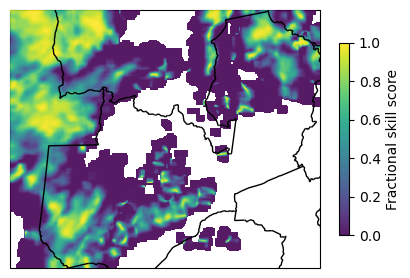

In [20]:
# Plot skill map
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,projection=ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831))

img = ax.imshow(
    skill_map, origin='lower',
    extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
    zorder=10,
    alpha = 0.9
)

ax.add_feature(cfeature.BORDERS, zorder=10)
ax.coastlines(zorder=10)
plt.colorbar(img, shrink=0.5, label='Fractional skill score')
plt.savefig(date + '_spatial_skill_score_all.png', bbox_inches='tight', dpi = dpi_set)

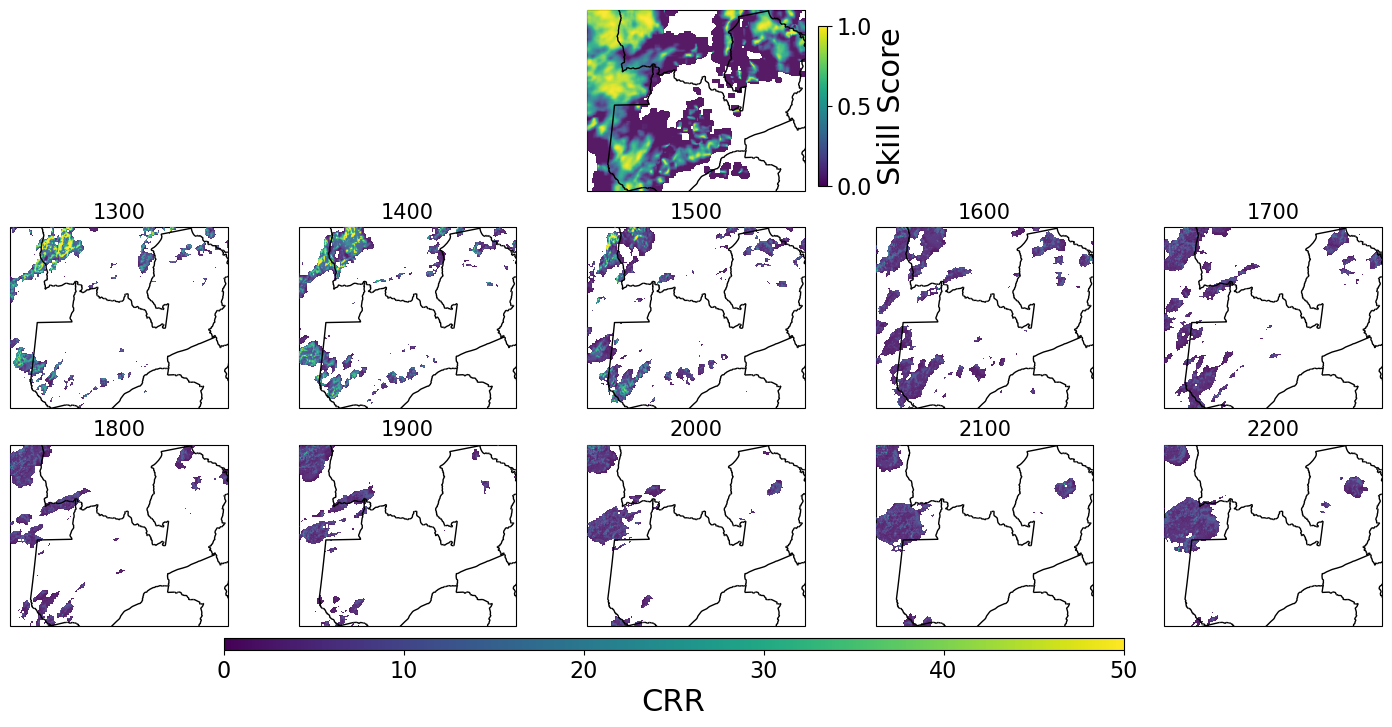

In [21]:
# Plot skill map
fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(3,5,3,projection=ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831))

img = ax.imshow(
    skill_map, origin='lower',
    extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
    zorder=10,
    alpha = 0.9
)

ax.add_feature(cfeature.BORDERS, zorder=10)
ax.coastlines(zorder=10)

cbar_ax = fig.add_axes([0.58, 0.66, 0.005, 0.2])
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), cax=cbar_ax, orientation='vertical')
cbar.set_label(label='Skill Score', size=22)
cbar.ax.tick_params(labelsize=16)

#plt.colorbar(img, shrink=0.5, label='Fractional skill score')

for i in range(10):
    
    ax = fig.add_subplot(3,5,5+i+1,projection=ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831))
    
    img = ax.imshow(
        np.where(all_obs[i]==0,np.nan,all_obs[i]), origin='lower',
        extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
        zorder=10,
        alpha = 0.9
    )
    plt.title(all_times[i], fontsize=15)
    
    ax.add_feature(cfeature.BORDERS, zorder=10)
    ax.coastlines(zorder=10)

#plt.colorbar(img, shrink=0.8, label='CRR')
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.015])
norm = mpl.colors.Normalize(vmin=np.nanmin(all_obs), vmax=np.nanmax(all_obs))
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), cax=cbar_ax, orientation='horizontal')
cbar.set_label(label='CRR', size=22)
cbar.ax.tick_params(labelsize=16)

plt.savefig(date + '_spatial_skill_score_tinits.png', bbox_inches='tight', dpi = dpi_set)
plt.show()